In [1]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from src.utils.data_utils import get_related_videos_with_keywords, keyword_searcher
from src.utils.general_utils import plot_wordcloud
from src.utils.evaluation_utils import diff_in_diff

# supress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_PATH = "../data"

In [ ]:
# # Note: this dataset is created using script in src/scripts/sport_videos.py

# # Load sports category videos dataset (with descriptions and tags)
# pq_sports = pq.ParquetFile(os.path.join(DATA_PATH, "filtered_sport_category_metadata.parquet"))
# df_vd_sports = pq_sports.read().to_pandas()

# # Change upload_date to datetime
# df_vd_sports["upload_date"] = pd.to_datetime(df_vd_sports["upload_date"], format="%Y-%m-%d %H:%M:%S")

In [3]:
df_vd_sports = pd.read_parquet(DATA_PATH+"/filtered_sport_category_metadata.parquet",engine="fastparquet")
# Change upload_date to datetime
df_vd_sports["upload_date"] = pd.to_datetime(df_vd_sports["upload_date"], format="%Y-%m-%d %H:%M:%S")

In [4]:
df_vd_sports.head(5)

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:57.427254,Can I catch 100 lbs of catfish LIVE. Me and Ja...,35.0,JOeSxtcNdHQ,8620,1673.0,"catfishing,fishing,fishing challenge,catfish,c...",Catching 100 lbs of Catfish 🔴Live,2019-10-01,48737.0
1,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:58.108323,,15.0,EPMLTw2zINw,355,1297.0,,big cat,2019-10-01,19999.0
2,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:58.773085,Are you ready to enter the high fashion world ...,78.0,Y1_pK68iSYQ,603,3305.0,"Catfishing,how to catch catfish,fishing,classy...",Classy Catfishing - How to Catch Catfish the P...,2019-09-28,58518.0
3,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:59.465346,Saltwater fishing out of Newquay Cornwall UK. ...,70.0,jF8TSo3ZfTc,1426,1889.0,"Fishing,Fishing uk,Angling,Sea angling,sea ang...",2 Day Saltwater Fishing Catch & Cook - UK Sea ...,2019-09-21,71998.0
4,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:40:00.188768,My family spent 3 weeks touring England and fi...,73.0,Gp00dNaVouo,990,2699.0,"Fishing,catfish,wels catfish,how to catch catf...",How to Catch Wels Catfish - Fishing for Catfis...,2019-09-14,101924.0


In [6]:
def get_all_tags(df: pd.DataFrame) -> list[str]:
    df['tags'] = df['tags'].str.lower()
    df['tags'] = df['tags'].str.replace("world cup", "world_cup")
    df['tags'] = df['tags'].str.replace("table tennis", "table_tennis")
    df['tags'] = df['tags'].str.replace("ping pong", "table_tennis")
    
    all_tags = []
    for tags in df['tags']:
        tag_list = tags.split(",") # "a, b c, d" -> ["a", "b c", "d"]
        for sentence in tag_list:
            all_tags.extend(sentence.split()) # "b c" -> ["b", "c"]
    
    return all_tags

In [7]:
all_tags_sport = get_all_tags(df_vd_sports)

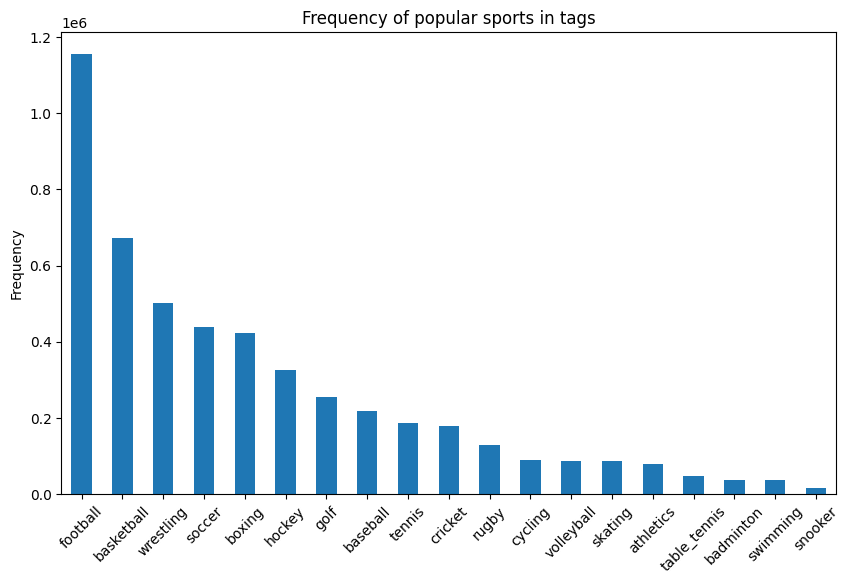

In [9]:
# Frequency of sports in tags
tag_counts = Counter(all_tags_sport)
del all_tags_sport

popular_sports = [
    "soccer", "football", "cricket", "hockey", 
    "tennis", "volleyball", "baseball", "rugby", 
    "golf", "snooker", "basketball", "skating",
    "swimming", "wrestling", "table_tennis", "badminton",
    "cycling", "boxing", "athletics"
]

popular_sports_counts = {sport: tag_counts[sport] for sport in popular_sports}

plt.figure(figsize=(10, 6))
popular_sports_counts_series = pd.Series(popular_sports_counts)
popular_sports_counts_series.sort_values(ascending=False).plot(kind="bar")
plt.title("Frequency of popular sports in tags")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [25]:
del all_tags_sport

In [17]:
popular_sports_counts

{'soccer': 438656,
 'football': 1154881,
 'cricket': 179255,
 'hockey': 325752,
 'tennis': 186430,
 'volleyball': 88421,
 'baseball': 218368,
 'rugby': 128249,
 'golf': 254322,
 'snooker': 15704,
 'basketball': 673750,
 'skating': 87190,
 'swimming': 36133,
 'wrestling': 502270,
 'table_tennis': 46836,
 'badminton': 36416,
 'cycling': 90398,
 'boxing': 422907,
 'athletics': 78689}

---
## martial art Analysis

- Judo
- Brazilian Jiu Jitsu. Brazilian jiu jitsu
- Karate
- Kickboxing
- Kung Fu
- Mixed Martial Arts
- Wrestling
- Taekwondo

In [10]:
martial_art = [
    'karate', 'taekwondo', 'judo', 'aikido', 'hapkido', 'kung fu', 
    'muay thai', 'capoeira', 'silat', 'savate', 'kendo', 'iaido', 
    'eskrima', 'sumo', 'boxing', 'kickboxing', 'mma', 'brazilian jiu-jitsu', 
    'sambo', 'wrestling', 'vale tudo', 'shootfighting', 'fencing', 
    'kyudo', 'krabi-krabong', 'pankration', 'lethwei', 'shorinji kempo', 
    'mongolian wrestling', 'gatka', 'jeet kune do', 'combat sambo', 
    'krav maga', 'systema'
]

martial_art_counts = {sport: tag_counts[sport] for sport in martial_art}

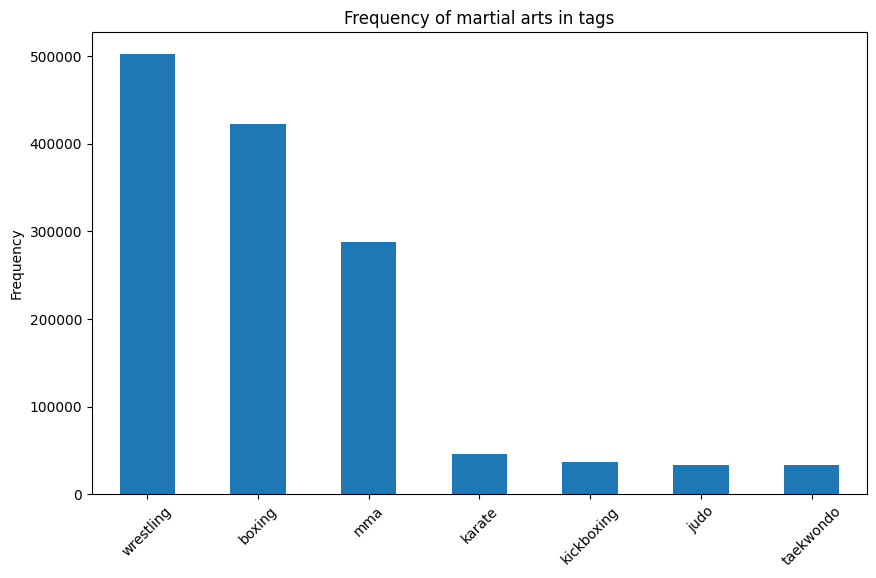

In [26]:
filtered_martial_art_counts = {k: v for k, v in martial_art_counts.items() if v >= 10000}
f_martial_art={k for k, v in martial_art_counts.items() if v >= 10000}
plt.figure(figsize=(10, 6))
filtered_martial_art_counts_series = pd.Series(filtered_martial_art_counts)
filtered_martial_art_counts_series.sort_values(ascending=False).plot(kind="bar")
plt.title("Frequency of martial arts in tags")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

---
## time series analysis

For Popular sport

In [77]:
monthly_counts = pd.DataFrame()
popular_sports = [
    "soccer", "football", "cricket", "hockey", 
    "tennis", "volleyball", "baseball", "rugby", 
    "golf", "snooker", "basketball", "skating",
    "swimming", "wrestling", "table_tennis", "badminton",
    "cycling", "boxing", "athletics"
]
for sport in popular_sports:
    sport_data = df_vd_sports[df_vd_sports['tags'].apply(lambda x: sport in x.split(','))]
    monthly_data = sport_data.groupby(sport_data['upload_date'].dt.to_period('M')).size()
    monthly_counts[sport] = monthly_data

<Figure size 1200x800 with 0 Axes>

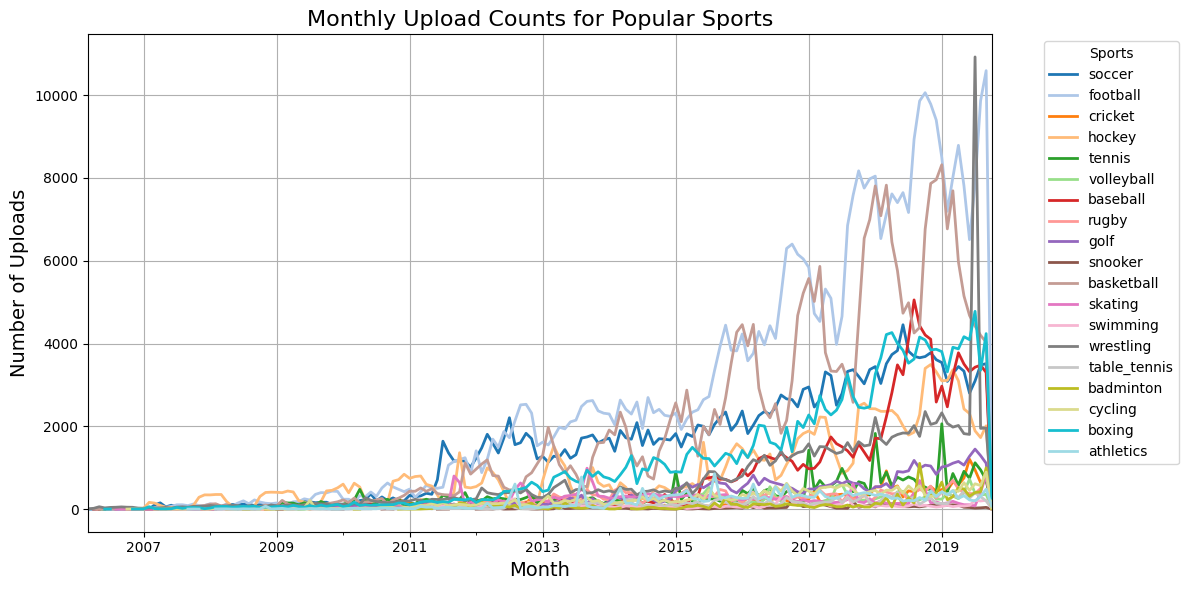

In [78]:
plt.figure(figsize=(12, 8))
monthly_counts.plot(kind='line', figsize=(12, 6), colormap='tab20', linewidth=2)

plt.title('Monthly Upload Counts for Popular Sports', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Uploads', fontsize=14)
plt.legend(title='Sports', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

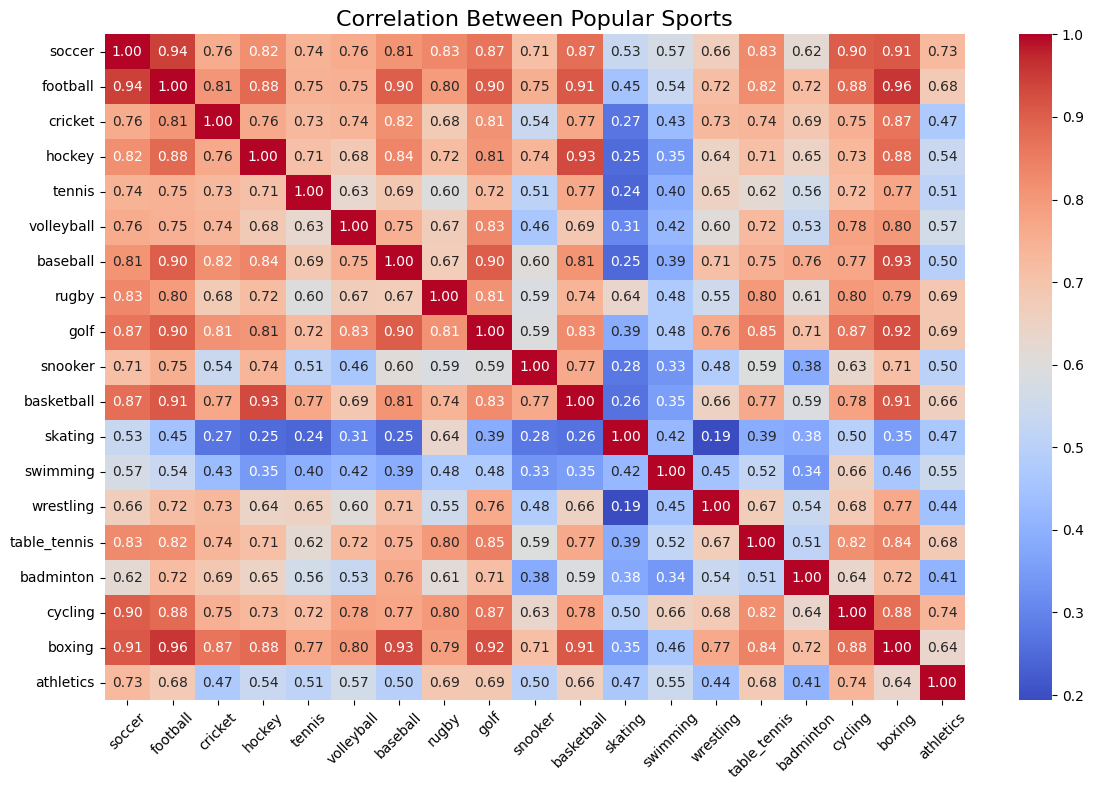

In [79]:
monthly_counts = monthly_counts.fillna(0)
correlation_matrix = monthly_counts.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Between Popular Sports", fontsize=16)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

For martial sport

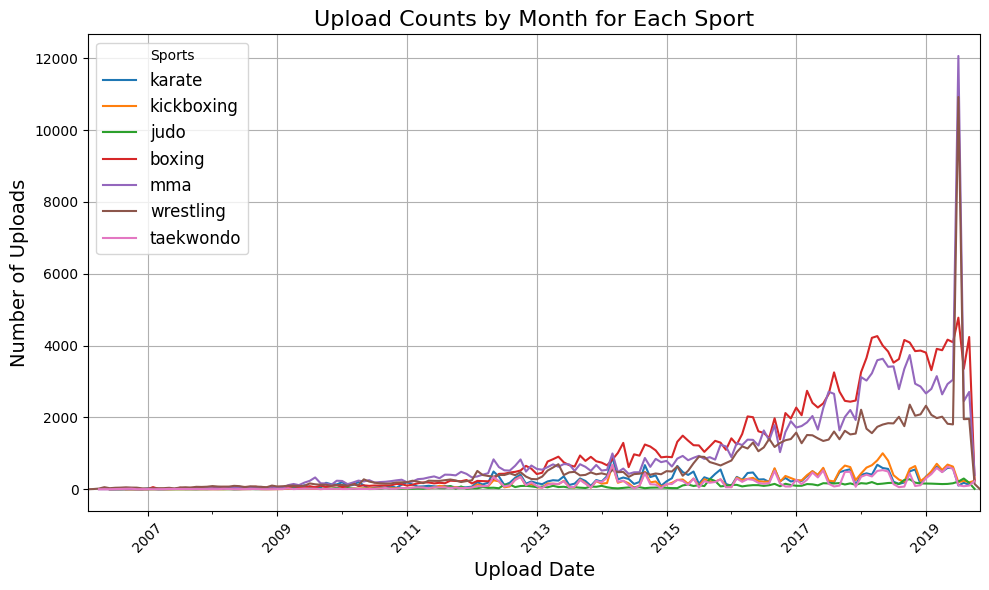

In [ ]:

plt.figure(figsize=(10, 6))
for sport in f_martial_art:
    sport_data= df_vd_sports[df_vd_sports['tags'].apply(
        lambda x: sport in x.split(',')
    )]
    monthly_data = sport_data.groupby(sport_data['upload_date'].dt.to_period('M')).size()
    monthly_data.plot(kind='line',label=sport)

plt.title('Upload Counts by Month for Each Sport', fontsize=16)
plt.xlabel('Upload Date', fontsize=14)
plt.ylabel('Number of Uploads', fontsize=14)
plt.legend(title='Sports', loc='upper left', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)  # 日付軸のラベルを回転
plt.tight_layout()  # レイアウト調整

# グラフの表示
plt.show()

### London Olympic

In [19]:
df_vd_sports_2012 = df_vd_sports[(df_vd_sports['upload_date'].dt.year >= 2011) & (df_vd_sports['upload_date'].dt.year <= 2013)]

In [72]:
olympic_sports_2012 = [
    'athletics', 'swimming', 'diving', 'synchronised swimming',
    'water polo', 'football', 'tennis', 'rowing', 'hockey',
    'boxing', 'volleyball',  'beach volleyball', 'gymnastics',
    'artistic gymnastics', 'rhythmic gymnastics', 'trampoline', 'basketball', 'wrestling',
    'sailing', 'weightlifting', 'handball', 'cycling', 'table_tennis',
    'equestrian', 'fencing', 'judo', 'shooting', 'rifle shooting',
    'skeet shooting', 'modern pentathlon', 'canoeing', 'archery',
    'badminton', 'taekwondo', 'triathlon'
]
f_olympic_sports_2012=[]
for sport in olympic_sports_2012:
    sport_data= df_vd_sports_2012[df_vd_sports_2012['tags'].apply(
        lambda x: sport in x.split(',')
    )]
    # filter the sport that has more than 4000 videos over 2011-2013
    if sport_data.shape[0]>4000:
        f_olympic_sports_2012.append(sport)

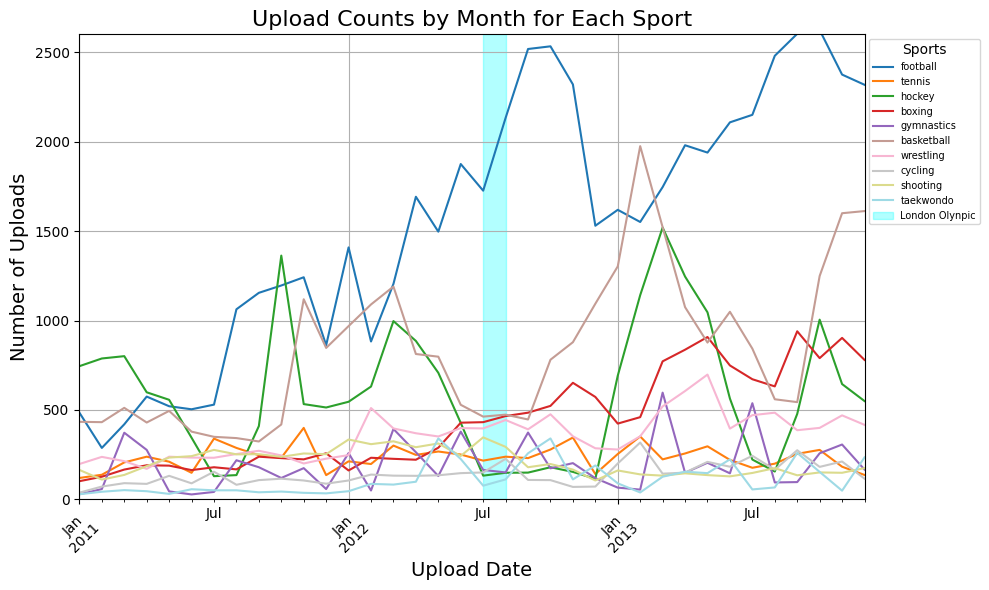

In [73]:
colors = plt.cm.get_cmap('tab20', len(f_olympic_sports_2012))
plt.figure(figsize=(10, 6))
for idx,sport in enumerate(f_olympic_sports_2012):
    sport_data= df_vd_sports_2012[df_vd_sports_2012['tags'].apply(
        lambda x: sport in x.split(',')
    )]
    monthly_data = sport_data.groupby(sport_data['upload_date'].dt.to_period('M')).size()
    monthly_data.plot(kind='line',label=sport,color=colors(idx))
    # daily_data = sport_data.groupby(sport_data['upload_date']).size()
    # daily_data.plot(kind='line',label=sport,color=colors(idx))

highlight_start = pd.to_datetime('2012-07-27')
highlight_end = pd.to_datetime('2012-08-12')
plt.axvspan(highlight_start, highlight_end, color='cyan', alpha=0.3, label='London Olynpic')

plt.title('Upload Counts by Month for Each Sport', fontsize=16)
plt.xlabel('Upload Date', fontsize=14)
plt.ylabel('Number of Uploads', fontsize=14)
plt.legend(title='Sports', loc='upper left', fontsize=7,bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()  
# plt.xlim(pd.to_datetime('2012-01-01'), pd.to_datetime('2012-12-31'))
plt.ylim(0,2600)
plt.show()

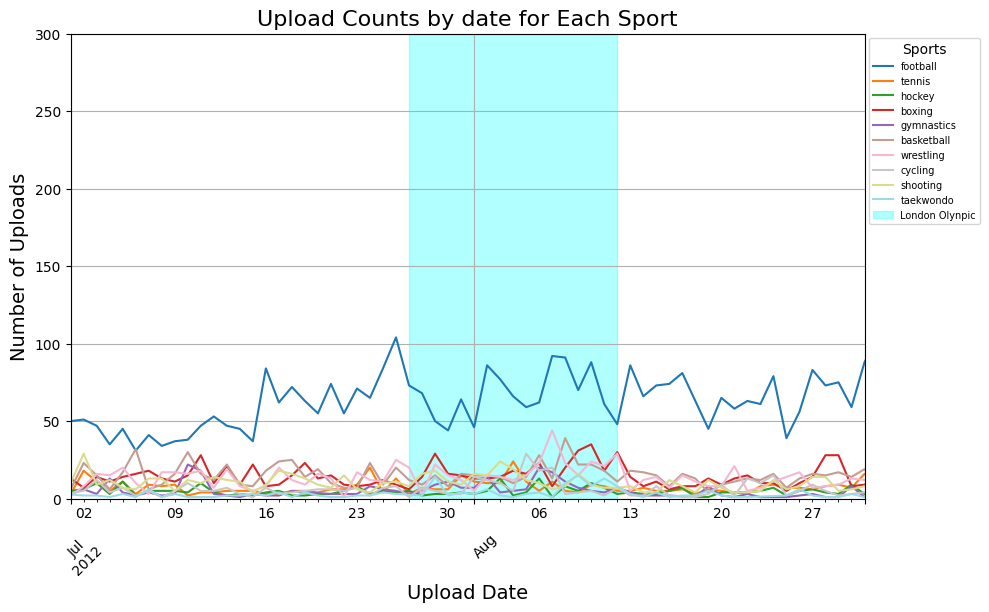

In [74]:

colors = plt.cm.get_cmap('tab20', len(f_olympic_sports_2012))
plt.figure(figsize=(10, 6))
for idx,sport in enumerate(f_olympic_sports_2012):
    sport_data= df_vd_sports_2012[df_vd_sports_2012['tags'].apply(
        lambda x: sport in x.split(',')
    )]
    # monthly_data = sport_data.groupby(sport_data['upload_date'].dt.to_period('M')).size()
    # monthly_data.plot(kind='line',label=sport,color=colors(idx))
    daily_data = sport_data.groupby(sport_data['upload_date']).size()
    daily_data.plot(kind='line',label=sport,color=colors(idx))

highlight_start = pd.to_datetime('2012-07-27')
highlight_end = pd.to_datetime('2012-08-12')
plt.axvspan(highlight_start, highlight_end, color='cyan', alpha=0.3, label='London Olynpic')

plt.title('Upload Counts by date for Each Sport', fontsize=16)
plt.xlabel('Upload Date', fontsize=14)
plt.ylabel('Number of Uploads', fontsize=14)
plt.legend(title='Sports', loc='upper left', fontsize=7,bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.xlim(pd.to_datetime('2012-07-01'), pd.to_datetime('2012-8-31'))
plt.ylim(0,300)
plt.show()

Non-olynpic sport in 2012

In [67]:
non_olympic_sports_2012 = [
    "cricket", "rugby", "snooker", "skating", 
    "karate", "kickboxing", "muay_thai", "squash", "billiards", 
    "bowling", "baseball", "softball", "hunting", "polo"
]
f_non_olympic_sports_2012=[]
for sport in non_olympic_sports_2012:
    sport_data= df_vd_sports_2012[df_vd_sports_2012['tags'].apply(
        lambda x: sport in x.split(',')
    )]
    # print(sport_data.shape)
    # filter the sport that has more than 4000 videos over 2011-2013
    if sport_data.shape[0]>4000:
        f_non_olympic_sports_2012.append(sport)

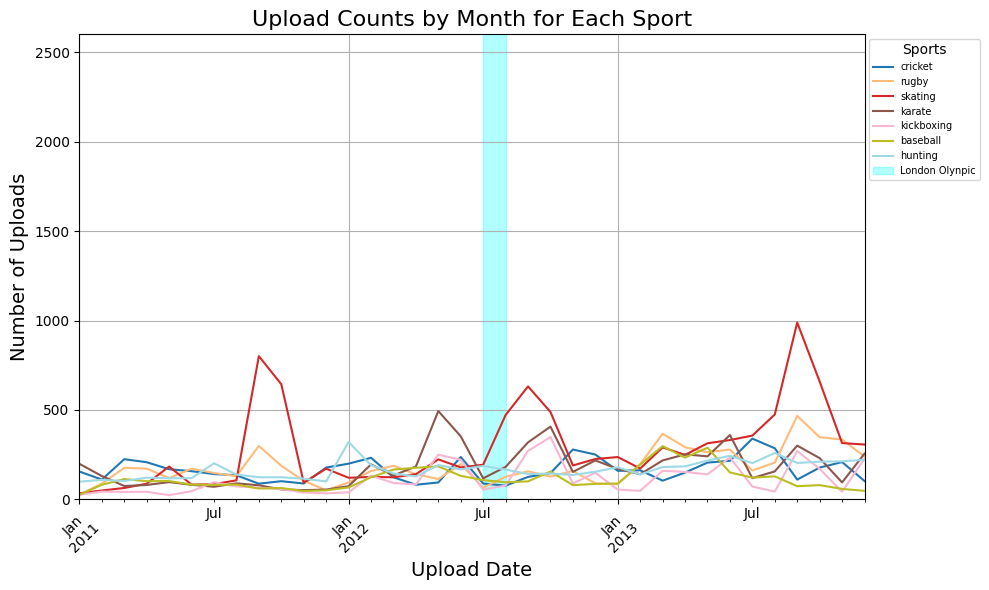

In [71]:
colors = plt.cm.get_cmap('tab20', len(f_non_olympic_sports_2012))
plt.figure(figsize=(10, 6))
for idx,sport in enumerate(f_non_olympic_sports_2012):
    sport_data= df_vd_sports_2012[df_vd_sports_2012['tags'].apply(
        lambda x: sport in x.split(',')
    )]
    monthly_data = sport_data.groupby(sport_data['upload_date'].dt.to_period('M')).size()
    monthly_data.plot(kind='line',label=sport,color=colors(idx))
    # daily_data = sport_data.groupby(sport_data['upload_date']).size()
    # daily_data.plot(kind='line',label=sport,color=colors(idx))

highlight_start = pd.to_datetime('2012-07-27')
highlight_end = pd.to_datetime('2012-08-12')
plt.axvspan(highlight_start, highlight_end, color='cyan', alpha=0.3, label='London Olynpic')

plt.title('Upload Counts by Month for Each Sport', fontsize=16)
plt.xlabel('Upload Date', fontsize=14)
plt.ylabel('Number of Uploads', fontsize=14)
plt.legend(title='Sports', loc='upper left', fontsize=7,bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()  
# plt.xlim(pd.to_datetime('2012-01-01'), pd.to_datetime('2012-12-31'))
plt.ylim(0,2600)
plt.show()

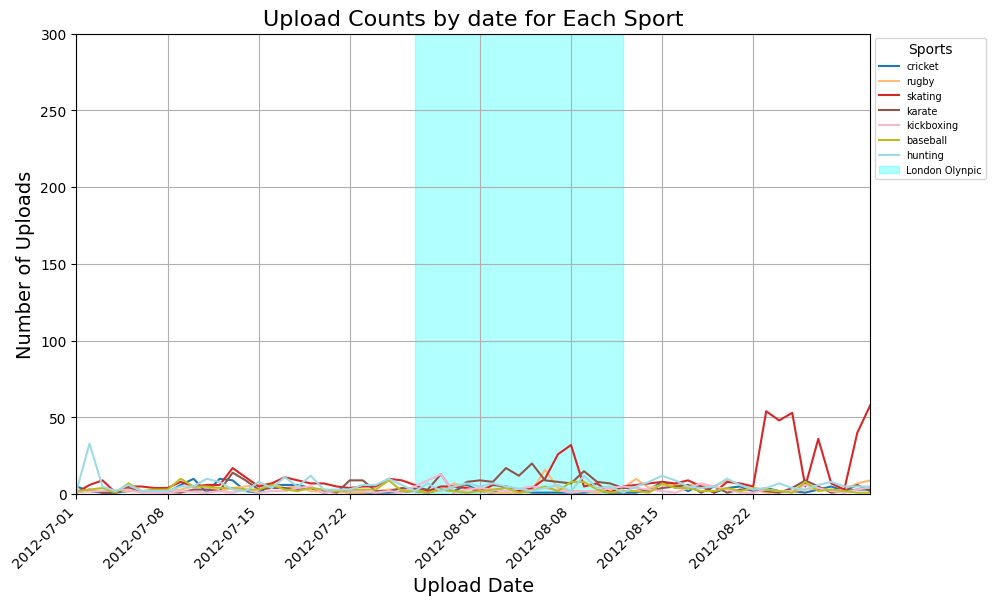

In [75]:
colors = plt.cm.get_cmap('tab20', len(f_non_olympic_sports_2012))
plt.figure(figsize=(10, 6))
for idx,sport in enumerate(f_non_olympic_sports_2012):
    sport_data= df_vd_sports_2012[df_vd_sports_2012['tags'].apply(
        lambda x: sport in x.split(',')
    )]
    # monthly_data = sport_data.groupby(sport_data['upload_date'].dt.to_period('M')).size()
    # monthly_data.plot(kind='line',label=sport,color=colors(idx))
    daily_data = sport_data.groupby(sport_data['upload_date']).size()
    daily_data.plot(kind='line',label=sport,color=colors(idx))

highlight_start = pd.to_datetime('2012-07-27')
highlight_end = pd.to_datetime('2012-08-12')
plt.axvspan(highlight_start, highlight_end, color='cyan', alpha=0.3, label='London Olynpic')

plt.title('Upload Counts by date for Each Sport', fontsize=16)
plt.xlabel('Upload Date', fontsize=14)
plt.ylabel('Number of Uploads', fontsize=14)
plt.legend(title='Sports', loc='upper left', fontsize=7,bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.xlim(pd.to_datetime('2012-07-01'), pd.to_datetime('2012-8-31'))
plt.ylim(0,300)
plt.show()